# Telegram News Segmentation

### Описание:
> Разработка модели сегментации новостей для Telegram, позволяющей автоматически группировать и классифицировать новости по релевантным темам. Целью данной работы является создание алгоритма, способного эффективно обрабатывать и анализировать новостной поток в мессенджере Telegram, чтобы помочь пользователям получать более релевантную и структурированную информацию.\
\
Схема работы модели выглядит следующим образом:
- Получение потока новостей и поиск уникальных новостей (например: 5 разных новостей об одном концерте будут считаться за **одну** уникальную новость)
- Категоризация уникальных новостей по различным темам: `society`, `sports`, `economy`, `entertainment`, `technology`, `other` (другие темы или не новости)

## 1. Data preparation and preprocessing

#### 1.1. Data Collection and Preprocessing

> Сбор данных для датасета на основе уже размеченных наборов данных и парсинга телеграмм-групп, с целью получения максимально информативных и однородных данных. Процесс очистки собранных данных, работа с выбросами и пустыми ячейками.

Импорт хорошо размеченного набора данных (первоначально взятого из репозитория github: https://github.com/IlyaGusev/tgcontest).

Набор данных содержит следующую структуру:
- **description**: содержание новости из телеграмма
- **category**: название темы (одно из следующих: society, sports, economy, entertainment, technology, other)
- **cluster**: идентификатор (id) кластера, содержащего дубликаты одной и той же новости ("-1" означает, что новость уникальна и не имеет дубликатов).

In [ ]:
!wget -O data_labeled.csv https://drive.usercontent.google.com/u/0/uc?id=1Q-AfLPl0whWzKTxvcvMnxX-C745Ez-DR&export=download

--2024-05-16 12:18:34--  https://drive.usercontent.google.com/u/0/uc?id=1Q-AfLPl0whWzKTxvcvMnxX-C745Ez-DR
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.62.132, 2607:f8b0:4004:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.62.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1Q-AfLPl0whWzKTxvcvMnxX-C745Ez-DR [following]
--2024-05-16 12:18:34--  https://drive.usercontent.google.com/uc?id=1Q-AfLPl0whWzKTxvcvMnxX-C745Ez-DR
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Q-AfLPl0whWzKTxvcvMnxX-C745Ez-DR [following]
--2024-05-16 12:18:34--  https://drive.usercontent.google.com/download?id=1Q-AfLPl0whWzKTxvcvMnxX-C745Ez-DR
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaitin

Импорт моего, вручную-размеченного, набора данных (собранного на основе парсинга новостей telegram за последний месяц)
Реализацию парсера каналов telegram можно найти здесь: https://github.com/hiuggo/telegram-news-segmentation.

Каналы, использованные в парсинге (отобраны на основе топ-чартов Telegram-каналов по различным тематикам: https://tgstat.ru/ratings/channels/public)

> Economy
- @novosti_voinaa, @breakingmash, @readovkanews, @ostorozhno_novosti, @tele_eve

> Sports
- @Match_TV, @twodrotsshow, @sportazarto, @zhfootballll, @footballhourss

> Economy
- @investkingyru, @tinkoff_invest_official, @banksta, @bankrollo, @omyinvestments

> Entertainment
- @kinopoisk, @plus_yndx, @mskgigs, @mskevents_ru, @concerts_moscow

> Technology
- @naebnet, @GPTMainNews, @hiaimedia, @NewHiTech9, @PROTechnology_news

In [ ]:
!wget -O custom_news.csv https://drive.usercontent.google.com/u/0/uc?id=1bjKGnoprhU6aGSOrGvl9mGJRYBkzBweJ&export=download

--2024-05-16 12:18:35--  https://drive.usercontent.google.com/u/0/uc?id=1bjKGnoprhU6aGSOrGvl9mGJRYBkzBweJ
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.62.132, 2607:f8b0:4004:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.62.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1bjKGnoprhU6aGSOrGvl9mGJRYBkzBweJ [following]
--2024-05-16 12:18:35--  https://drive.usercontent.google.com/uc?id=1bjKGnoprhU6aGSOrGvl9mGJRYBkzBweJ
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1bjKGnoprhU6aGSOrGvl9mGJRYBkzBweJ [following]
--2024-05-16 12:18:35--  https://drive.usercontent.google.com/download?id=1bjKGnoprhU6aGSOrGvl9mGJRYBkzBweJ
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaitin

In [ ]:
import json
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

LABELS = ['society', 'sports', 'economy', 'entertainment', 'technology', 'other']

df = pd.read_csv('data_labeled.csv')
print('Dataset Size:', df.shape[0])
df.head()

Dataset Size: 751


,description,category,cluster
0,"Мэр Краснодара отстранил от работы чиновников,...",society,-1
1,Перед обстрелом рэперов HammAli & Navai в Липе...,society,-1
2,Альтернативный маршрут для передвижения маломо...,society,-1
3,В Свердловской области за выходные два человек...,society,-1
4,Первые жертвы тумана - в Мелитополе ДТП на про...,society,-1


> Процесс визуализации данных с помощью "гистограммы" (histogram) и "ящика с усами" (boxplot)

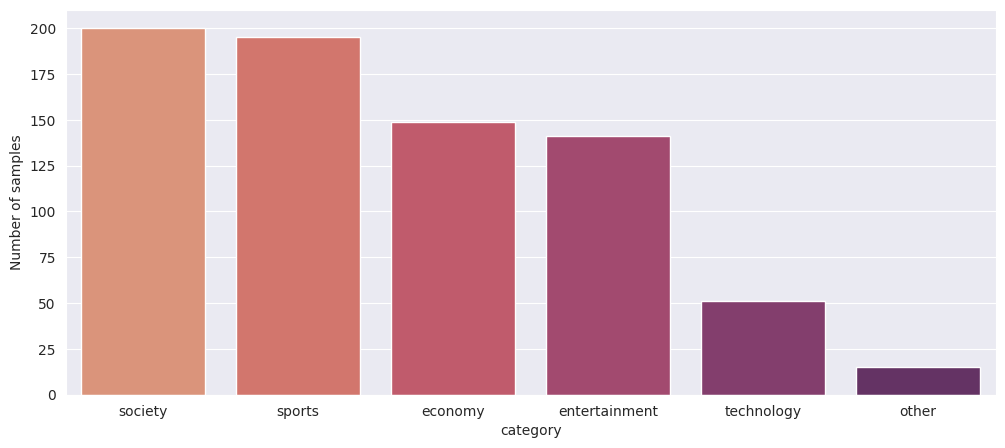

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

bins = df.category.value_counts().rename_axis('category').reset_index(name='counts')

fig = plt.figure(figsize=(12, 5))
sns.set_style('darkgrid')
palette = sns.color_palette('flare')
sns.barplot(data=bins, x='category', y='counts', hue=LABELS, palette=palette, order=LABELS)
plt.ylabel('Number of samples')
plt.show()

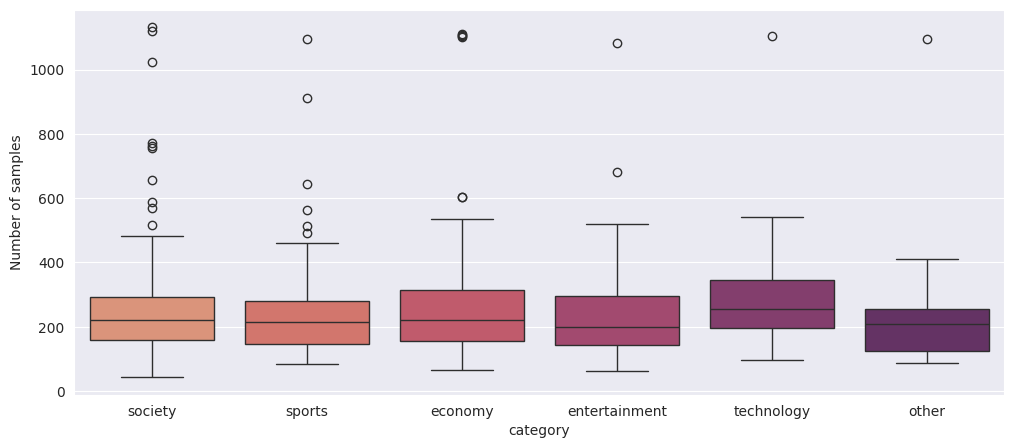

In [ ]:
bins = pd.DataFrame(data={'desc_len': df.description.str.len().values, 'category': df.category.values})

fig = plt.figure(figsize=(12, 5))
sns.set_style('darkgrid')
palette = sns.color_palette('flare')
sns.boxplot(data=bins, x='category', y='desc_len', palette=palette, order=LABELS)
plt.ylabel('Number of samples')
plt.show()

In [ ]:
df_clean = pd.read_csv('custom_news.csv')

print('Dataset Size:', df_clean.shape[0])
df_clean.head(10)

Dataset Size: 1068


,description,category,cluster
0,📊 Как закрылась основная торговая сессия на ро...,economy,0
1,📊 Как закрылась основная торговая сессия на ро...,economy,0
2,📊 Как закрылась основная торговая сессия на ро...,economy,0
3,​​Начали Инвестутро и уже обсуждаем свежие нов...,economy,1
4,​​Начали Инвестутро и уже обсуждаем свежие нов...,economy,1
5,​​SFI определилась с суммой дивидендов по итог...,economy,2
6,"​​🚗 Дивиденды подъехали. Соллерс объявила, ско...",economy,2
7,"​​Мал золотник, да дорог. Селигдар определился...",economy,2
8,​​🐟 Дивиденды на закуску Совет директоров Инар...,economy,2
9,​​Европлан определился с размером дивидендов. ...,economy,2


In [ ]:
print('Duplicate news count on each topic:')
for label in LABELS:
  print(f'- {label}:'.ljust(17), df_clean[(df_clean.category == label) & (df_clean.cluster != -1)].shape[0], '/', df_clean[df_clean.category == label].shape[0])

Duplicate news count on each topic:
- society:        147 / 230
- sports:         46 / 225
- economy:        192 / 223
- entertainment:  24 / 194
- technology:     13 / 178
- other:          0 / 18


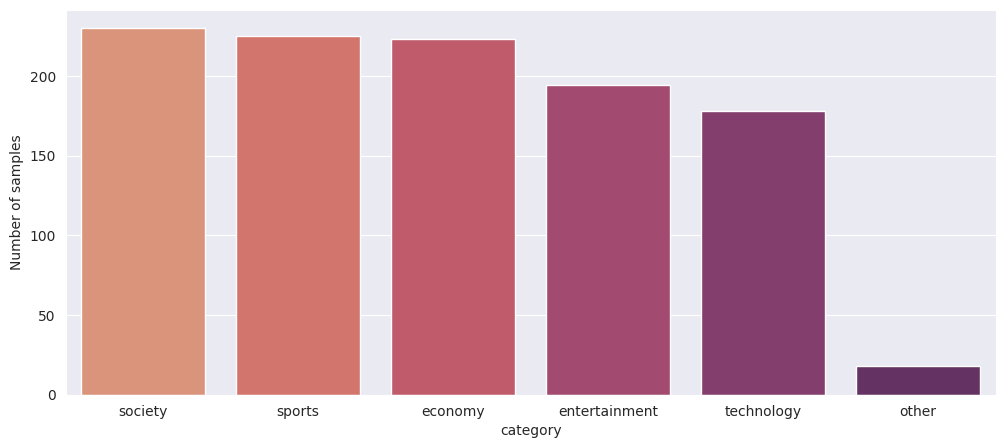

In [ ]:
bins = df_clean.category.value_counts().rename_axis('category').reset_index(name='counts')

fig = plt.figure(figsize=(12, 5))
sns.set_style('darkgrid')
palette = sns.color_palette('flare')
sns.barplot(data=bins, x='category', y='counts', palette=palette, order=LABELS)
plt.ylabel('Number of samples')
plt.show()

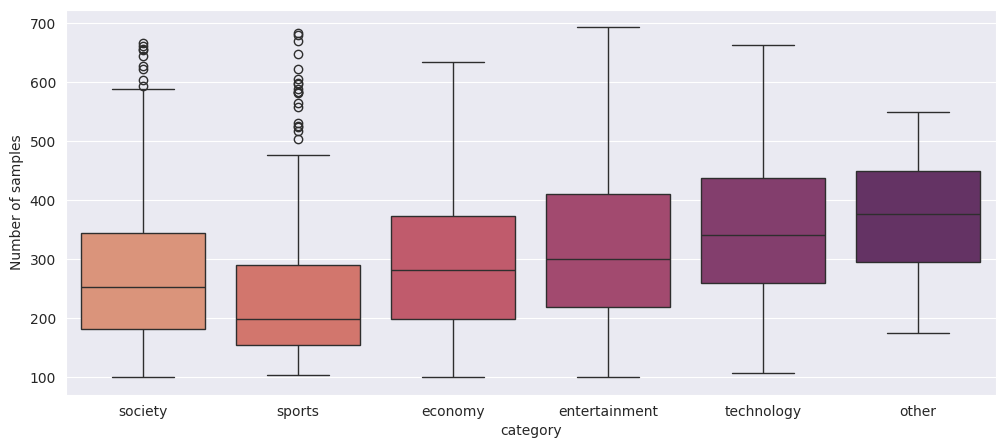

In [ ]:
bins = pd.DataFrame(data={'desc_len': df_clean.description.str.len().values, 'category': df_clean.category.values})

fig = plt.figure(figsize=(12, 5))
sns.set_style('darkgrid')
palette = sns.color_palette('flare')
sns.boxplot(data=bins, x='category', y='desc_len', palette=palette, order=LABELS)
plt.ylabel('Number of samples')
plt.show()

In [ ]:
def drop_news_duplicates(df):
    df_ = df.copy()
    df_['desc_len'] = df_clean.description.str.len()
    df_clust_centroids = df_[df_.cluster != -1].groupby(by='cluster').max()[['description', 'category']]
    return pd.concat([df_clust_centroids, df_[df_.cluster == -1][['description', 'category']]])

df_full = drop_news_duplicates(pd.concat([df, df_clean]))

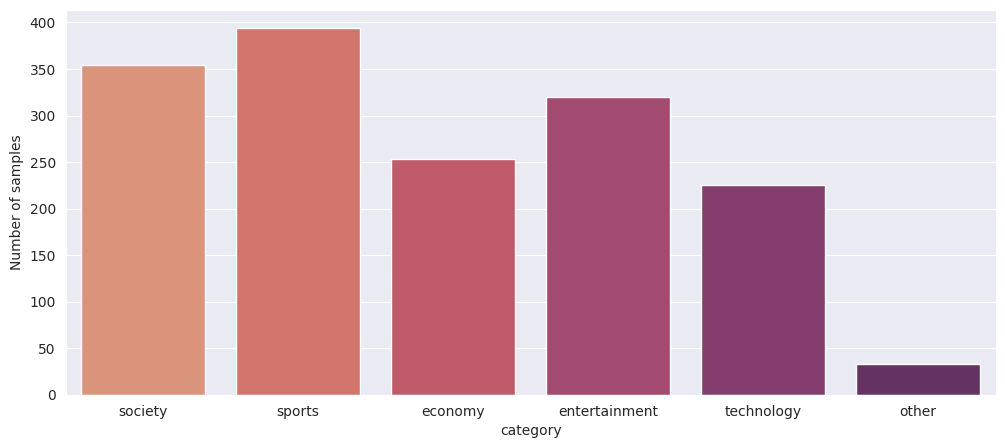

In [ ]:
bins = df_full.category.value_counts().rename_axis('category').reset_index(name='counts')

fig = plt.figure(figsize=(12, 5))
sns.set_style('darkgrid')
palette = sns.color_palette('flare')
sns.barplot(data=bins, x='category', y='counts', palette=palette, order=LABELS)
plt.ylabel('Number of samples')
plt.show()

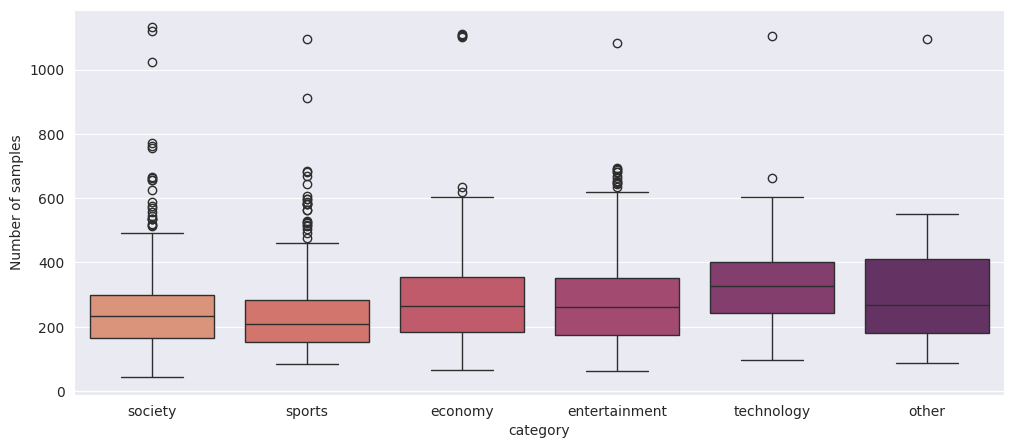

In [ ]:
bins = pd.DataFrame(data={'desc_len': df_full.description.str.len().values, 'category': df_full.category.values})

fig = plt.figure(figsize=(12, 5))
sns.set_style('darkgrid')
palette = sns.color_palette('flare')
sns.boxplot(data=bins, x='category', y='desc_len', palette=palette, order=LABELS)
plt.ylabel('Number of samples')
plt.show()

#### 1.2. Data Splitting

> Разделение данных на тренировочный/тестовый датасеты, применение алгоритма **TF-IDF**, библиотеки **nltk** и библиотеки **spacy** для эффективного кодирования текста в векторное представление с максимальной информативностью и минимальным шумом (путем удаления *стоп-слов* и различных *знаков препинаний*)

In [ ]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 67.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import spacy

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))
punctuation = set(string.punctuation)

nlp = spacy.load('ru_core_news_sm')

def preprocess_and_lemmatize_text(text):
    doc = nlp(text.lower())
    lemmatized_words = [token.lemma_ for token in doc if token.text not in punctuation and token.text not in stop_words]
    return " ".join(lemmatized_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### 1.2.1 TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency)
> TF-IDF — это статистическая мера, используемая для оценки важности слова в контексте документа относительно всех других документов в корпусе. TF-IDF объединяет два основных компонента:
1. **TF (Term Frequency)**: Частота термина в документе, которая отражает, насколько часто слово встречается в данном документе.
2. **IDF (Inverse Document Frequency)**: Обратная частота документа, которая измеряет редкость слова в корпусе. Слова, встречающиеся в меньшем количестве документов, получают больший вес.

> Плюсы:
* **Простота и эффективность**: TF-IDF является простым в реализации и достаточно эффективным методом для взвешивания терминов.
* **Чувствительность к контексту**: Хорошо отражает важность слов в конкретном документе относительно других документов.
* **Отсутствие зависимости от больших корпусов**: В отличие от моделей, требующих большого объема данных для обучения (например, Word2Vec и FastText), TF-IDF можно эффективно использовать даже на небольших наборах данных.
* **Устойчивость к часто встречающимся словам**: Слова, которые встречаются в большинстве документов (например, "и", "или"), получают низкий вес, что позволяет сосредоточиться на более значимых терминах.

> Минусы:
* **Отсутствие семантической информации**: TF-IDF не учитывает семантическую схожесть слов, что может привести к игнорированию синонимов и связанных терминов.
* **Чувствительность к документам одинаковой длины**: TF-IDF может давать смещённые результаты для документов разной длины, так как не нормализует частоты терминов.
* **Неподходящ для глубокого анализа**: Ограниченные возможности для захвата сложных языковых структур и отношений между словами по сравнению с современными методами на основе нейросетей.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

X = df_full['description'].apply(preprocess_and_lemmatize_text)
X = tfidf_vectorizer.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(df_full['category'])

CPU times: user 1min 7s, sys: 247 ms, total: 1min 8s
Wall time: 1min 33s


In [ ]:
%%time

# For news de-duplication task
test_X = df_clean['description'].apply(preprocess_and_lemmatize_text)
test_X = tfidf_vectorizer.transform(test_X)

test_y = le.fit_transform(df_clean['category'])

CPU times: user 35.6 s, sys: 111 ms, total: 35.7 s
Wall time: 39 s


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train/test (with preserving class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [ ]:
X.shape, y.shape

((1579, 11769), (1579,))

In [ ]:
import joblib

# Save our tf-idf vectorizer (for final pipeline)
joblib.dump(tfidf_vectorizer, 'tfidf_news_vectorizer.pkl')

['tfidf_news_vectorizer.pkl']

## 2. Model training

### 2.1. News De-Duplication Task

> Дедубликация новостей представляет собой процесс выявления и удаления дублирующихся новостных статей, которые могут быть перефразированными или слегка измененными копиями друг друга. Это важная задача для обеспечения разнообразия контента и повышения качества информационных потоков. Для выполнения этой задачи можно использовать различные алгоритмы машинного обучения, включая традиционные методы кластеризации, такие как HDBSCAN, OPTICS и DBSCAN.

In [ ]:
!pip install hdbscan

In [ ]:
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score, normalized_mutual_info_score

def print_score_seg(y_pred, y_test):
    print(f'Adjusted Rand Index: {adjusted_rand_score(y_test, y_pred):.4f}')
    print(f'Normalized Mutual Information: {normalized_mutual_info_score(y_test, y_pred):.4f}')
    print(f'Fowlkes-Mallows Index: {fowlkes_mallows_score(y_test, y_pred):.4f}\n')

#### 2.1.1. HDBSCAN

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)
> HDBSCAN является улучшенной версией алгоритма DBSCAN, которая использует иерархический подход для обнаружения кластеров разной плотности. HDBSCAN не требует явного задания минимального числа точек (min_samples), а вместо этого строит
иерархическую дендограмму кластеров и использует адаптивные пороги плотности

> Плюсы:
* **Автоматическое определение кластеров разной плотности**: HDBSCAN может обнаруживать кластеры с разной плотностью, что делает его гибким для различных типов данных.
* **Устойчивость к шуму**: HDBSCAN эффективно выделяет шумовые точки, что повышает точность кластеризации.
* **Отсутствие необходимости в точном определении параметров**: Нет необходимости заранее задавать количество кластеров или другие чувствительные параметры.

> Минусы:
* **Высокая вычислительная сложность**: Алгоритм может быть медленным на больших наборах данных.
* **Параметр минимального размера кластера**: Хотя HDBSCAN автоматизирует выбор порогов плотности, все же требуется задание минимального размера кластера, что может быть неочевидным.

In [ ]:
%%time
from hdbscan import HDBSCAN

hdbscan_clust = HDBSCAN(min_cluster_size=2)
hdbscan_clust.fit(test_X)

print_score_seg(hdbscan_clust.labels_, df_clean.cluster)

Adjusted Rand Index: 0.2988
Normalized Mutual Information: 0.5915
Fowlkes-Mallows Index: 0.5338

CPU times: user 142 ms, sys: 24.7 ms, total: 167 ms
Wall time: 206 ms


#### 2.1.2 OPTICS
OPTICS (Ordering Points To Identify the Clustering Structure)

> OPTICS расширяет возможности DBSCAN, предоставляя упорядочение точек данных так, чтобы можно было легко определять плотностные структуры данных на разных масштабах. В отличие от DBSCAN, OPTICS не выделяет кластеры явно, а создает упорядочение, которое можно анализировать для обнаружения кластеров

> Плюсы:
* **Обнаружение кластеров на разных масштабах**: OPTICS позволяет визуализировать плотностные структуры и определять кластеры разной плотности.
* **Гибкость**: Алгоритм хорошо работает на данных с неравномерной плотностью кластеров.

> Минусы:
* **Сложность интерпретации**: Для выделения кластеров из упорядоченных данных требуется дополнительный анализ, что может быть затруднительно.
* **Производительность**: Алгоритм может быть сильно медленным на больших наборах данных.

In [ ]:
%%time
from sklearn.cluster import OPTICS

optics_clust = OPTICS(eps=1., min_samples=2)
optics_clust.fit(test_X.A)

print_score_seg(optics_clust.labels_, df_clean.cluster)

Adjusted Rand Index: 0.7514
Normalized Mutual Information: 0.8802
Fowlkes-Mallows Index: 0.8379

CPU times: user 2min 23s, sys: 1min 16s, total: 3min 40s
Wall time: 3min 5s


#### 2.1.3 DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

> DBSCAN является одним из самых известных алгоритмов плотностной кластеризации. Он группирует точки, находящиеся в областях с высокой плотностью, и отмечает точки в областях с низкой плотностью как шумовые (cluster="-1"). Алгоритм требует задания двух основных параметров: радиуса окрестности (eps), минимального числа точек в кластере (min_samples)

> Плюсы:
* **Простота реализации**: DBSCAN относительно прост в реализации и использовании.
* **Устойчивость к шуму**: Алгоритм хорошо выделяет шумовые точки, что позволяет улучшить качество кластеризации.
* **Автоматическое определение числа кластеров**: Не требуется заранее задавать количество кластеров.

> Минусы:
* **Чувствительность к параметрам**: Результаты сильно зависят от выбора параметров eps и minPts, которые могут быть трудными для настройки.
* **Проблемы с кластерами переменной плотности**: DBSCAN плохо справляется с данными, содержащими кластеры разной плотности.

In [ ]:
%%time
from sklearn.cluster import DBSCAN

dbscan_clust = DBSCAN(eps=1., min_samples=2)
dbscan_clust.fit(test_X)

print_score_seg(dbscan_clust.labels_, df_clean.cluster)

Adjusted Rand Index: 0.9030
Normalized Mutual Information: 0.9465
Fowlkes-Mallows Index: 0.9404

CPU times: user 2 s, sys: 0 ns, total: 2 s
Wall time: 1.84 s


In [ ]:
print('DBSCAN info:')
cluster_count = len(np.unique(dbscan_clust.labels_))
print('- Unique news count:', (dbscan_clust.labels_ == -1).sum(), '/', dbscan_clust.labels_.shape[0])
print('- Total duplicate clusters:', cluster_count-1)

DBSCAN info:
- Unique news count: 670 / 1068
- Total duplicate clusters: 171


### 2.2. News Classification Task

> Классификация новостей является важной задачей в области обработки естественного языка (NLP) и машинного обучения. Цель заключается в том, чтобы автоматически присваивать новостным статьям определённые категории (н-ер: `экономика`, `развлечения`, `общество`, `спорт`, `технологии`, итд). Для выполнения этой задачи можно использовать различные традиционные модели машинного обучения, такие как Multinomial Naive Bayes (MultinomialNB), логистическая регрессия (LogisticRegression) и случайный лес (RandomForest).

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def print_score_clf(model, X_test, y_test):
    y_pred = model.predict(X_test)
    lbls = list(range(6))
    prec = list(precision_score(y_test, y_pred, average=None, labels=lbls).round(4))
    prec.append(round(sum(prec)/len(prec), 4))

    recall = list(recall_score(y_test, y_pred, average=None, labels=lbls).round(4))
    recall.append(round(sum(recall)/len(recall), 4))

    f1score = list(f1_score(y_test, y_pred, average=None, labels=lbls).round(4))
    f1score.append(round(sum(f1score)/len(f1score), 4))

    y_true_bin = label_binarize(y_test, classes=lbls)
    y_pred_bin = label_binarize(y_pred, classes=lbls)

    auc = [round(roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i]), 4) for i in range(len(LABELS))]
    auc.append(round(sum(auc)/len(auc), 4))

    df = pd.DataFrame(data={'Precision': prec, 'Recall': recall, 'F1-Score': f1score, 'ROC-AUC': auc}, index=[*le.classes_]+['mean']).T
    return df[LABELS+['mean']]

#### 2.2.1. MultinomialNB

Multinomial Naive Bayes (MultinomialNB)
> Multinomial Naive Bayes — это простой и эффективный алгоритм для классификации текстов. Он основан на теореме Байеса и предполагает, что присутствие каждого слова в документе независимо от других слов.

> Плюсы:
* **Быстрота и эффективность**: Алгоритм быстрый и требует небольших вычислительных ресурсов, что делает его подходящим для обработки больших объемов данных.
* **Простота реализации**: Легко реализуется и требует минимальной настройки гиперпараметров.
* **Хорошие результаты на текстовых данных**: Часто показывает конкурентоспособные результаты для задач текстовой классификации.

> Минусы:
* **Сильные предположения**: Предположение о независимости слов может не соответствовать реальным данным, что может ограничивать точность модели.
* **Чувствительность к редким словам**: Модель может быть чувствительна к редким словам, что может повлиять на качество классификации.

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

print_score_clf(model_nb, X_test, y_test)

CPU times: user 38.5 ms, sys: 1.36 ms, total: 39.9 ms
Wall time: 39.2 ms


,society,sports,economy,entertainment,technology,other,mean
Precision,0.7049,0.6991,0.9265,0.9135,0.8824,0.0,0.6877
Recall,0.9085,1.0000,0.6238,0.7422,0.5000,0.0,0.6291
F1-Score,0.7938,0.8229,0.7456,0.8190,0.6383,0.0,0.6366
ROC-AUC,0.8991,0.9283,0.8072,0.8622,0.7445,0.5,0.7902


#### 2.2.2. Logistic Regression

Logistic Regression (Логистическая регрессия)
> Логистическая регрессия — это линейная модель для классификации, которая использует логистическую функцию для предсказания вероятности принадлежности образца к определённому классу.

> Плюсы:
* **Интерпретируемость**: Модель легко интерпретировать, так как веса признаков показывают их вклад в принятие решений.
* **Хорошо работает на линейно разделимых данных**: Эффективна, если данные линейно разделимы или почти линейно разделимы.
* **Гибкость**: Может использовать регуляризацию (L1 и L2) для предотвращения переобучения и улучшения обобщающей способности.

> Минусы:
* **Линейность**: Предполагает линейную зависимость между признаками и целевым классом, что может быть ограничением для более сложных данных.
* **Чувствительность к мультиколлинеарности**: Присутствие сильно коррелированных признаков может повлиять на стабильность модели.

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

print_score_clf(model_lr, X_test, y_test)

CPU times: user 1.32 s, sys: 1.04 s, total: 2.36 s
Wall time: 1.46 s


,society,sports,economy,entertainment,technology,other,mean
Precision,0.6535,0.9438,0.8780,0.8644,0.8824,1.0000,0.8704
Recall,0.9296,0.9557,0.7129,0.7969,0.6667,0.1538,0.7026
F1-Score,0.7674,0.9497,0.7869,0.8293,0.7595,0.2667,0.7266
ROC-AUC,0.8934,0.9684,0.8470,0.8826,0.8260,0.5769,0.8324


#### 2.2.3. Random Forest

Random Forest Classifier (Случайный лес)
> Random Forest — это ансамблевый метод, который строит множество решающих деревьев и объединяет их предсказания для улучшения точности и устойчивости модели.

> Плюсы:
* **Высокая точность**: Часто достигает высокой точности за счёт комбинирования результатов множества деревьев.
* **Устойчивость к переобучению**: Использование случайного подмножества признаков и данных при построении деревьев уменьшает риск переобучения.
* **Обработка нелинейных данных**: Эффективно работает с данными, имеющими сложные нелинейные зависимости.

> Минусы:
* **Сложность и вычислительная затратность**: Модель может быть медленной и требовать значительных вычислительных ресурсов, особенно на больших наборах данных.
* **Меньшая интерпретируемость**: В отличие от логистической регрессии, результаты Random Forest сложнее интерпретировать.

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

print_score_clf(model_rf, X_test, y_test)

CPU times: user 1.41 s, sys: 8.52 ms, total: 1.41 s
Wall time: 1.45 s


,society,sports,economy,entertainment,technology,other,mean
Precision,0.6095,0.8994,0.7826,0.8273,0.9623,1.0000,0.8468
Recall,0.9014,0.9051,0.7129,0.7109,0.5667,0.6154,0.7354
F1-Score,0.7273,0.9022,0.7461,0.7647,0.7133,0.7619,0.7693
ROC-AUC,0.8670,0.9357,0.8376,0.8366,0.7815,0.8077,0.8444


#### 2.2.4. ruBERT-tiny2

> ruBERT-tiny2 — это облегчённая версия русскоязычной модели BERT, созданная для ускорения обработки и уменьшения вычислительных ресурсов. Модель сохраняет основные преимущества BERT, включая двунаправленное внимание и способность учитывать контекст, но является более компактной и быстрой.

> Плюсы:
* **Компактность и быстрота**: Модель маленькая и быстрая, требует меньше ресурсов по сравнению с полными версиями BERT, что делает её подходящей для приложений с ограниченными вычислительными возможностями.
* **Контекстуальное понимание**: Способна эффективно захватывать контекст слов благодаря двунаправленному вниманию, что улучшает качество классификации.
* **Готовая для использования на русском языке**: Предобученная на большом корпусе русскоязычных текстов, что делает её особенно эффективной для задач на русском языке.

> Минусы:
* **Потеря некоторой точности**: Уменьшенная модель может показывать немного меньшую точность по сравнению с полными версиями BERT из-за компромиссов, связанных с её размером.
* **Сложность настройки**: Несмотря на предобученность, тонкая настройка модели для специфической задачи может быть сложной и требовать значительных вычислительных ресурсов и данных.

In [ ]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer

base_model = 'cointegrated/rubert-tiny2'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained(base_model)
model = BertForSequenceClassification.from_pretrained(base_model, num_labels=len(LABELS), problem_type='multi_label_classification')
model.to(device)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [ ]:
model.config.label2id = {label: i for i, label in enumerate(LABELS)}
model.config.id2label = {i: label for i, label in enumerate(LABELS)}

In [ ]:
from sklearn.preprocessing import LabelBinarizer

X = df_full['description'].apply(lambda text: tokenizer(text.lower(), truncation=True)).values

lb = LabelBinarizer()
y = lb.fit_transform(df_full['category']).astype(float)

In [ ]:
# Split data into train/test/val (60% / 20% / 20%) (with preserving class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
X_train.shape[0], X_test.shape[0], X_val.shape[0]

(947, 316, 316)

In [ ]:
# Preparing datasets for training
train_dict = [{**X_train[i], 'label': y_train[i]} for i in range(X_train.shape[0])]
test_dict = [{**X_test[i], 'label': y_test[i]} for i in range(X_test.shape[0])]
val_dict = [{**X_val[i], 'label': y_val[i]} for i in range(X_val.shape[0])]

In [ ]:
from tqdm.auto import tqdm, trange
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from IPython.display import display

# Verify the accuracy of the model on test data
def evaluate_model(model, dev_dataloader, verbose=False, labels=None):
    facts, preds = predict_with_model(model, dev_dataloader)
    aucs = get_classification_report(facts, preds, labels)
    if verbose:
        print('aucs:', aucs, np.mean(aucs))
    return np.mean(aucs)

# Get model prediction
def predict_with_model(model, dataloader):
    preds = []
    facts = []

    for batch in tqdm(dataloader):
        facts.append(batch.labels.cpu().numpy())
        batch = batch.to(model.device)
        with torch.no_grad():
            pr = model(input_ids=batch.input_ids, attention_mask=batch.attention_mask, token_type_ids=batch.token_type_ids)
        preds.append(torch.softmax(pr.logits, -1).cpu().numpy())
    facts = np.concatenate(facts)
    preds = np.concatenate(preds)
    return facts, preds

# Obtain the results of the model
def get_classification_report(facts, preds, labels=None, verbose=True):
    if verbose:
        print(facts.shape, preds.shape)
    return [roc_auc_score(facts[:, i], preds[:, i]) for i in range(len(LABELS))]

In [ ]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer)
batch_size = 64

# Create training and test (validation) data for model training
train_dataloader = DataLoader(
    train_dict,
    batch_size=batch_size, drop_last=False, shuffle=True, num_workers=0, collate_fn=data_collator
)
dev_dataloader = DataLoader(
    val_dict,
    batch_size=batch_size, drop_last=False, shuffle=True, num_workers=0, collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dict + val_dict, # same X_test as before
    batch_size=batch_size, drop_last=False, shuffle=True, num_workers=0, collate_fn=data_collator
)

In [ ]:
import gc
import torch

# Cleaning up unnecessary data during training
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [ ]:
# Testing the accuracy of the model
evaluate_model(model, dev_dataloader, verbose=True)

  0%|          | 0/5 [00:00<?, ?it/s]

(316, 6) (316, 6)
aucs: [0.433609022556391, 0.5671502976190477, 0.19741100323624594, 0.5502155791894222, 0.40522352187149496, 0.34227142271422717] 0.4159801411978048


0.4159801411978048

In [ ]:
# Selecting the optimal model parameters (default parameters for model `rubert-tiny2`)
n_epochs = 40
cleanup_step = 100
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)

In [ ]:
# Train the model
for epoch in range(n_epochs):
    model.train()
    cleanup()

    tq = tqdm(train_dataloader)
    for i, batch in enumerate(tq):
        # Compute the loss function (loss)
        try:
            batch = batch.to(model.device)
            output = model(**batch)
            loss = output.loss
            loss.backward()
        except RuntimeError as e:
            print('error on step', i, e)
            loss = None
            cleanup()
            continue

        # Updating the weights
        optimizer.step()
        optimizer.zero_grad()

        tq.set_description(f'loss: {loss.item():.4f}')

    # Testing the model's performance
    model.eval()
    eval_loss = evaluate_model(model, dev_dataloader, verbose=True)
    print(f'epoch {epoch + 1}, step {i}: train loss: {loss.item():.4f}  val auc: {eval_loss}\n')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(316, 6) (316, 6)
aucs: [0.526390977443609, 0.6937624007936508, 0.22977346278317148, 0.6127048002299511, 0.5249158788655665, 0.4447724477244772] 0.5053866613067376
epoch 1, step 14: train loss: 0.6697  val auc: 0.5053866613067376



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

LABELS = ['society', 'sports', 'economy', 'entertainment', 'technology', 'other']

# Get the predictions for each test
model.eval()
facts, preds = predict_with_model(model, test_dataloader)
preds[preds[:, 2] > 0.07] = [0., 0., 1., 0., 0., 0.] # p(other) > 0.07 is below 1%, hence tag prediction as `other`

precs = precision_score(facts.argmax(axis=1), preds.argmax(axis=1), average=None)
recall = recall_score(facts.argmax(axis=1), preds.argmax(axis=1), average=None)
f1score = f1_score(facts.argmax(axis=1), preds.argmax(axis=1), average=None)
aucs = get_classification_report(facts, preds, verbose=False)

df_bench = pd.DataFrame(data={'Precision': precs, 'Recall': recall, 'F1-score': f1score, 'ROC-AUC': aucs}, index=lb.classes_).T
df_bench['mean'] = [np.mean(precs), np.mean(recall), np.mean(f1score), np.mean(aucs)]

df_bench[LABELS+['mean']].round(4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save the `model` and the `tokenizer`
model.save_pretrained('/content/drive/MyDrive/news_segmentation_model')
tokenizer.save_pretrained('/content/drive/MyDrive/news_segmentation_model')

('/content/drive/MyDrive/news_segmentation_model/tokenizer_config.json',
 '/content/drive/MyDrive/news_segmentation_model/special_tokens_map.json',
 '/content/drive/MyDrive/news_segmentation_model/vocab.txt',
 '/content/drive/MyDrive/news_segmentation_model/added_tokens.json',
 '/content/drive/MyDrive/news_segmentation_model/tokenizer.json')

## 3. Model comparison

### 3.1. News De-Duplication Task

Для проверки качества модели в задаче неконтролируемого обучения (unsupervised learning task), мы используем следующие популярные метрики:

1. Adjusted Rand Index (ARI)
> Adjusted Rand Index измеряет сходство между двумя кластерами, скорректированное с учётом случайности. Значение ARI варьируется от -1 до 1, где 1 означает идеальное совпадение кластеров, 0 соответствует случайному распределению кластеров, а отрицательные значения указывают на хуже, чем случайное распределение.

2. Normalized Mutual Information (NMI)
> Normalized Mutual Information (NMI) измеряет степень информации, которую одни кластеры содержат о других, нормализованную для устранения влияния размера кластеров. Значения NMI варьируются от 0 до 1, где 1 означает полное совпадение кластеров.

3. Fowlkes-Mallows Index (FMI)
> Fowlkes-Mallows Index (FMI) оценивает сходство между двумя кластерами, измеряя геометрическое среднее точности и полноты. Значения FMI варьируются от 0 до 1, где 1 означает полное совпадение кластеров.

| Metrics | TF-IDF + HDBSCAN | TF-IDF + OPTICS | TF-IDF + DBSCAN |
|-----|--------|------|------------|
| Adjusted Rand Index (ARI) | 0.2988 | 0.7514 | **0.9030** |
| Normalized Mutual Information (NMI) | 0.5915 | 0.8802 | **0.9465** |
| Fowlkes-Mallows Index (FMI) | 0.5338 | 0.8379 | **0.9404** |


### 3.2. News Classification Task

Для проверки качества модели в задаче контролируемого обучения (supervised learning task), мы используем следующие популярные метрики:

1. Precision (Точность)
> Precision измеряет долю правильно предсказанных положительных классов среди всех предсказанных положительных классов. Значение precision варьируется от 0 до 1, где 1 означает, что все предсказанные положительные классы верны.

2. Recall (Полнота)
> Recall измеряет долю правильно предсказанных положительных классов среди всех реальных положительных классов. Значение recall варьируется от 0 до 1, где 1 означает, что модель находит все положительные классы.

3. F1-Score
> F1-Score является гармоническим средним между precision и recall. Значение F1-Score варьируется от 0 до 1, где 1 означает идеальный баланс между precision и recall.

4. ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)
> ROC-AUC измеряет качество бинарной классификационной модели, оценивая её способность различать положительные и отрицательные классы на различных порогах вероятностей. ROC-кривая (Receiver Operating Characteristic) отображает отношение между долей истинно положительных результатов (True Positive Rate, TPR или Recall) и долей ложно положительных результатов (False Positive Rate, FPR) при изменении порога классификации. Площадь под кривой (Area Under the Curve, AUC) варьируется от 0 до 1, где 1 означает идеальную модель, 0.5 — модель, работающую на уровне случайных предсказаний.

| Metrics | TF-IDF + MultinomialNB | TF-IDF + Logistic Regression | TF-IDF + Random Forest | ruBERT-tiny2 |
|---------------------|--------------------|---------------|---------------|-----|
| Precision | 0.6877 | 0.8704 | 0.8468 | **0.8894** |
| Recall | 0.6291 | 0.7026 | 0.7354 | **0.8500** |
| F1-Score | 0.6366 | 0.7266 | 0.7693 | **0.8652** |
| ROC-AUC | 0.7902 | 0.8324 | 0.8444 | **0.9859** |


## 4. Final Model Inference

> Загружаем ранее обученные модели, пишем функцию инференса для входных данных, загрузим неструктурированный датасет и тестируем его через нашу модель, оценив качество её работы.

### 4.1. Importing new unstructured data

In [ ]:
!wget -O data_test.csv https://drive.usercontent.google.com/u/0/uc?id=1JCCPyp-5yy3JfEPStzBRQ0IzJOER4Hh0&export=download

--2024-05-16 15:30:13--  https://drive.usercontent.google.com/u/0/uc?id=1JCCPyp-5yy3JfEPStzBRQ0IzJOER4Hh0
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.62.132, 2607:f8b0:4004:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.62.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1JCCPyp-5yy3JfEPStzBRQ0IzJOER4Hh0 [following]
--2024-05-16 15:30:13--  https://drive.usercontent.google.com/uc?id=1JCCPyp-5yy3JfEPStzBRQ0IzJOER4Hh0
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JCCPyp-5yy3JfEPStzBRQ0IzJOER4Hh0 [following]
--2024-05-16 15:30:13--  https://drive.usercontent.google.com/download?id=1JCCPyp-5yy3JfEPStzBRQ0IzJOER4Hh0
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaitin

In [ ]:
df_test = pd.read_csv('data_test.csv')
df_test.head()

,description
0,Нейросеть Kandinsky 3.1 открыли для всех польз...
1,Исполнительный директор от России в МВФ Алексе...
2,Комитет Госдумы по бюджету и налогам поддержал...
3,Дубай накрыли сильнейшие дожди. В городе закры...
4,Инфраструктура нужна всем. 38% покупателей пре...


### 4.2. Import pretrained models

#### 4.2.1 News De-Duplication Task

> Загружаем и создаем пайплайн для автоматической кластеризации неразмеченных новостей на кластеры, используя следующие действия:
- предобработку текста (лемманизация слов, удаление стоп-слов, знаков препинания)
- векторизация текста с помощью TF-IDF
- использованию DBSCAN модели (ранее хорошо предобученная для работы с новостными данными)

In [ ]:
import spacy
import string
from sklearn.cluster import DBSCAN

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))
punctuation = set(string.punctuation)

nlp = spacy.load('ru_core_news_sm')

def preprocess_and_lemmatize_text(text):
    doc = nlp(text.lower())
    lemmatized_words = [token.lemma_ for token in doc if token.text not in punctuation and token.text not in stop_words]
    return " ".join(lemmatized_words)

preprocess = np.vectorize(preprocess_and_lemmatize_text)
tfidf_news_vectorizer = joblib.load('tfidf_news_vectorizer.pkl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def deduplication_pipeline(data):
    data_clean = preprocess(data)
    data_vectorized = tfidf_news_vectorizer.transform(data_clean)
    dbscan_clust = DBSCAN(eps=1., min_samples=2)
    dbscan_clust.fit(data_vectorized)
    return dbscan_clust.labels_

def print_duplicate_clusters(data, labels):
    for i in range(-1, len(np.unique(labels))-1):
        print(f'Кластер: {i}')
        cluster = data[np.where(labels == i)][:5]
        for news in cluster:
            print('-', news)
        print()

In [ ]:
test = df_test['description'].values

In [ ]:
%%time
labels = deduplication_pipeline(test)
print('Number of unique clusters:', len(np.unique(labels)))

Number of unique clusters: 13
CPU times: user 21.4 s, sys: 51.3 ms, total: 21.4 s
Wall time: 21.9 s


In [ ]:
print_duplicate_clusters(test, labels) # -1 - Unique news

Кластер: -1
- Нейросеть Kandinsky 3.1 открыли для всех пользователей. Это новая версия генеративной модели, которая создает изображения по текстовому запросу.. Что нового:– Модель дополнительно обучена на базе эстетичных картинок, так что качество генерации стало в разы лучше;– Встроена языковая модель Giga. Chat Pro, благодаря которой появилась «бьютификация» (упрощение получения изображения при помощи улучшения текстового запроса);– Улучшена функция inpainting для редактуры отдельных деталей.
- Исполнительный директор от России в МВФ Алексей Можин сообщил, что в случае краха доллара и международной валютной системы, БРИКС может предложить альтернативу. Страны-участницы БРИКС могут создать учетную единицу, которая будет построена на корзине из валют пяти государств-членов объединения. Это китайский юань, индийская рупия, российский рубль, бразильский реал и южноафриканский ранд. @banksta
- Комитет Госдумы по бюджету и налогам поддержал кандидатуру Антона Силуанова на должность министр

In [ ]:
df_test['cluster'] = labels
df_test_unique = df_test.groupby(by='cluster').first()
df_test_unique # for news classification task, take random sample from each cluster

,description
cluster,
-1,Нейросеть Kandinsky 3.1 открыли для всех польз...
0,Среднемесячные зарплаты россиян станут больше ...
1,Заместителя министра обороны Тимура Иванова от...
2,"​​Мал золотник, да дорог. Селигдар определился..."
3,❗️Над Белгородом сработала русская ПВО Как соо...
4,В МВД разработали законопроект о введении угол...
5,В России с 25 апреля появятся электронные заче...
6,ВЭБ предложил улучшать демографию России иммиг...
7,В Бурятии вспыхнули пожары — там горит сухая т...


#### 4.2.2 News Classification Task

> Загружаем и создаем пайплайн для автоматической классификации неразмеченных новостей по основным тематикам, используя следующие действия:
- токенизация текста
- использование ruBERT-tiny2 модели (ранее хорошо предобученной для работы с категоризацией новостных данных)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer

model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/news_segmentation_model')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/news_segmentation_model')

In [ ]:
LABELS = ['economy', 'entertainment', 'society', 'sports', 'technology', 'other']
LABELS_RU = ['экономика', 'развлечения', 'другое', 'общество', 'спорт', 'технологии']

# Predicting topics based on news
@torch.no_grad()
def predict_topic(text):
  inputs = tokenizer(text, truncation=True, return_tensors='pt')
  inputs = inputs.to(model.device)

  outputs = model(**inputs)

  pred = torch.nn.functional.softmax(outputs.logits, dim=1)
  pred = pred.argmax(dim=1)

  return LABELS_RU[pred[0]]

# Probabilistic topic prediction based on news
@torch.no_grad()
def predict_topics(text):
    inputs = tokenizer(text, truncation=True, return_tensors='pt')
    inputs = inputs.to(model.device)

    outputs = model(**inputs)

    pred = torch.nn.functional.softmax(outputs.logits, dim=1)

    topics_list = {}
    for i in range(len(pred[0].tolist())):
        topics_list[LABELS_RU[i]] = round(pred[0].tolist()[i], 4)
    return topics_list

In [ ]:
for i, (sample,) in enumerate(df_test_unique.values):
    pred_topic = predict_topic(sample)
    print(f'{i+1}:'.ljust(4), (sample[:100]+'...').ljust(55), '|', pred_topic)

1:   Нейросеть Kandinsky 3.1 открыли для всех пользователей. Это новая версия генеративной модели, котора... | технологии
2:   Среднемесячные зарплаты россиян станут больше 100 тысяч рублей к 2027 году, обещает Минэкономразвити... | экономика
3:   Заместителя министра обороны Тимура Иванова отправили в СИЗО. Он будет находится под стражей 2 месяц... | общество
4:   ​​Мал золотник, да дорог. Селигдар определился с финальными дивидендами за прошлый год. Совет директ... | экономика
5:   ❗️Над Белгородом сработала русская ПВО Как сообщают жители Белгорода, в городе сработала русская ПВО... | общество
6:   В МВД разработали законопроект о введении уголовной ответственности за незаконный оборот банковских ... | общество
7:   В России с 25 апреля появятся электронные зачетки и студенческие билеты. Эксперимент будет доброволь... | экономика
8:   ВЭБ предложил улучшать демографию России иммигрантами из Африки и Латинской Америки. Это позволит ув... | экономика
9:   В Бурятии вспыхнули пожары — 

In [ ]:
for i, (sample,) in enumerate(df_test_unique.values):
    pred_topics = predict_topics(sample)
    print(f'{i+1}:'.ljust(4), (sample[:50]+'...').ljust(55), '|', pred_topics)

1:   Нейросеть Kandinsky 3.1 открыли для всех пользоват...   | {'экономика': 0.1541, 'развлечения': 0.1854, 'другое': 0.0471, 'общество': 0.0799, 'спорт': 0.0729, 'технологии': 0.4607}
2:   Среднемесячные зарплаты россиян станут больше 100 ...   | {'экономика': 0.5744, 'развлечения': 0.0633, 'другое': 0.0518, 'общество': 0.1212, 'спорт': 0.0516, 'технологии': 0.1377}
3:   Заместителя министра обороны Тимура Иванова отправ...   | {'экономика': 0.0854, 'развлечения': 0.0369, 'другое': 0.0605, 'общество': 0.7083, 'спорт': 0.056, 'технологии': 0.0528}
4:   ​​Мал золотник, да дорог. Селигдар определился с ф...   | {'экономика': 0.5267, 'развлечения': 0.0852, 'другое': 0.0458, 'общество': 0.0992, 'спорт': 0.0797, 'технологии': 0.1634}
5:   ❗️Над Белгородом сработала русская ПВО Как сообщаю...   | {'экономика': 0.0577, 'развлечения': 0.034, 'другое': 0.067, 'общество': 0.725, 'спорт': 0.0698, 'технологии': 0.0465}
6:   В МВД разработали законопроект о введении уголовно...   | {'экономика': 0.